Constructing kinetic energy matrix using Fourier Grid Hamiltonian...
Kinetic energy matrix constructed.

Calculating Born-Oppenheimer electronic structure with Rc = 1.50 Å
This solves the electronic Hamiltonian for parametric R values using FGH

Progress:
R = -4.00 Å (1/101)
R = -2.40 Å (21/101)
R = -0.80 Å (41/101)
R = +0.80 Å (61/101)
R = +2.40 Å (81/101)
R = +4.00 Å (101/101)


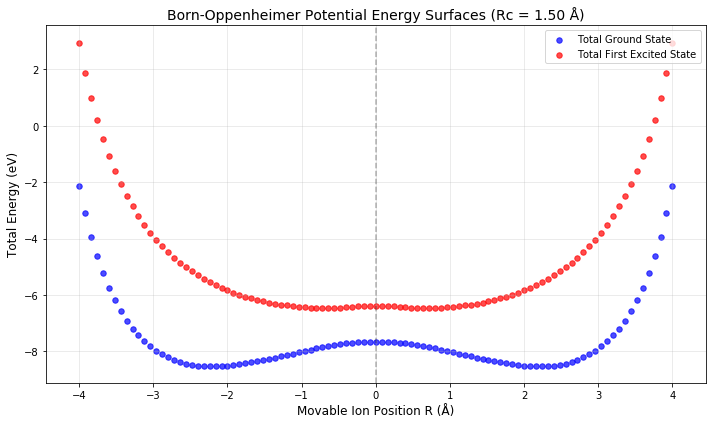


=== Analysis for Rc = 1.50 Å ===
Vb (barrier height): 0.873 eV
Band gap at R=0: 1.281 eV

Calculating Born-Oppenheimer electronic structure with Rc = 1.75 Å
This solves the electronic Hamiltonian for parametric R values using FGH

Progress:
R = -4.00 Å (1/101)
R = -2.40 Å (21/101)
R = -0.80 Å (41/101)
R = +0.80 Å (61/101)
R = +2.40 Å (81/101)
R = +4.00 Å (101/101)


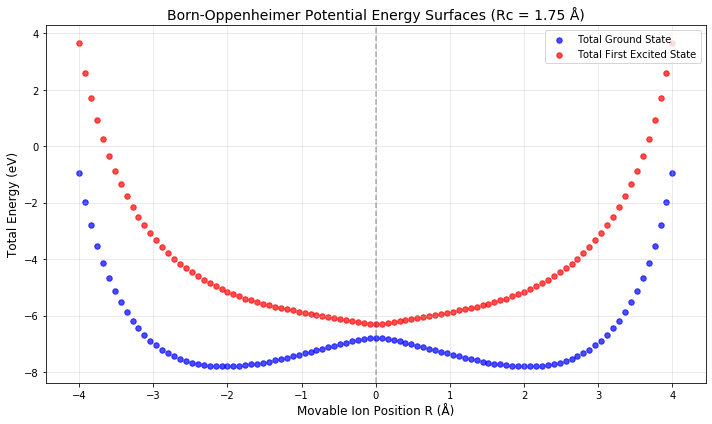


=== Analysis for Rc = 1.75 Å ===
Vb (barrier height): 1.004 eV
Band gap at R=0: 0.489 eV

Calculating Born-Oppenheimer electronic structure with Rc = 2.00 Å
This solves the electronic Hamiltonian for parametric R values using FGH

Progress:
R = -4.00 Å (1/101)
R = -2.40 Å (21/101)
R = -0.80 Å (41/101)
R = +0.80 Å (61/101)
R = +2.40 Å (81/101)
R = +4.00 Å (101/101)


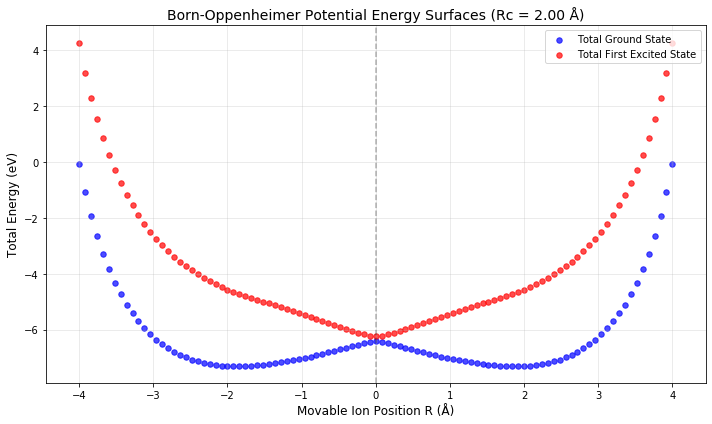


=== Analysis for Rc = 2.00 Å ===
Vb (barrier height): 0.896 eV
Band gap at R=0: 0.173 eV

Calculating Born-Oppenheimer electronic structure with Rc = 2.50 Å
This solves the electronic Hamiltonian for parametric R values using FGH

Progress:
R = -4.00 Å (1/101)
R = -2.40 Å (21/101)
R = -0.80 Å (41/101)
R = +0.80 Å (61/101)
R = +2.40 Å (81/101)
R = +4.00 Å (101/101)


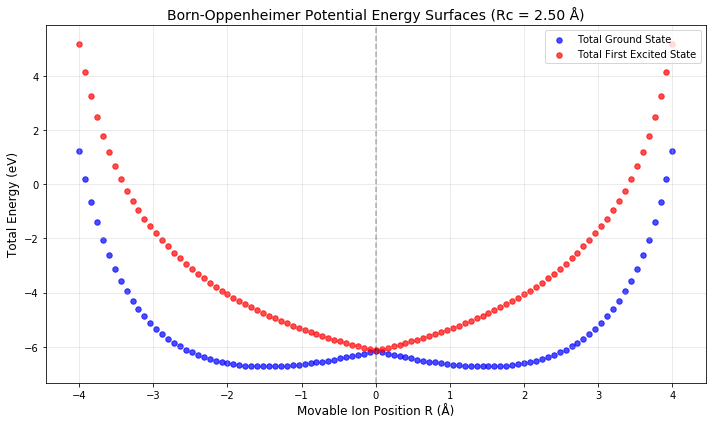


=== Analysis for Rc = 2.50 Å ===
Vb (barrier height): 0.549 eV
Band gap at R=0: 0.045 eV


In [1]:
# method 3 Fourier Grid Hamiltonian - Corrected for Atomic Units
#natural units
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.special import erf
import warnings
warnings.filterwarnings('ignore')

bohr_to_angstrom = 0.529177210903
hartree_to_eV = 27.211386245988
angstrom_to_bohr = 1.0 / bohr_to_angstrom

N = 1024  
xmax_angstrom = 10.0  # Å
xmax = xmax_angstrom * angstrom_to_bohr  
x = np.linspace(-xmax, xmax, N)
dx = x[1] - x[0]

K = np.pi / dx  
dk = 2 * np.pi / (N * dx)  

Z = 1.0
Rc_range = [1.5, 1.75, 2.0, 2.5]  
L_angstrom = 10.0  
L = L_angstrom * angstrom_to_bohr  

def construct_kinetic_matrix_fgh():
    T = np.zeros((N, N))
    
    # Prefactor in atomic units (ℏ²/2m_e = 1/2)
    prefactor = 0.5
    
    for i in range(N):
        for j in range(N):
            if i == j:
                # Diagonal elements
                T[i, j] = prefactor * (K**2 / 3) * (1 + 2 / N**2)
            else:
                # Off-diagonal elements
                diff = i - j
                sign = (-1)**diff
                sin_term = np.sin(np.pi * diff / N)**2
                T[i, j] = prefactor * (2 * K**2 / N**2) * sign / sin_term
    
    return T

def electron_ion_potential(r, Rc):
    r_abs = np.abs(r)
    
    mask_nonzero = r_abs > 1e-20
    
    V = np.zeros_like(r)
    V[mask_nonzero] = -Z * erf(r_abs[mask_nonzero]/Rc) / r_abs[mask_nonzero]
    
    mask_zero = ~mask_nonzero
    if np.any(mask_zero):
        V[mask_zero] = -Z * (2.0 / (np.sqrt(np.pi) * Rc))
    
    return V

def ion_ion_coulomb(r):
    if np.abs(r) < 1e-20:
        return np.inf
    return 1.0 / np.abs(r)  # In atomic units, V = 1/r

def electronic_potential(x, R, Rc):
    ion_positions = [-L/2, L/2]
    
    V_electronic = np.zeros_like(x)
    
    # Sum electron-ion interactions
    for ion_pos in ion_positions:
        V_electronic += electron_ion_potential(x - ion_pos, 1.5 * angstrom_to_bohr)
    V_electronic += electron_ion_potential(x - R, Rc)
    
    return V_electronic

def total_energy_at_R(electronic_energy, R):
    V_ion_ion = (ion_ion_coulomb(L) +           # between fixed ions at ±L/2
                 ion_ion_coulomb(R + L/2) +     # between movable ion at R and ion at -L/2
                 ion_ion_coulomb(R - L/2))      # between movable ion at R and ion at +L/2
    
    return electronic_energy + V_ion_ion

def compute_electronic_eigenvalues_fgh(V_electronic, T_matrix, n_states=2):
    V_matrix = np.diag(V_electronic)
    
    # Total Hamiltonian matrix
    H_matrix = T_matrix + V_matrix
    
    # Solve eigenvalue problem
    eigenvalues, eigenvectors = eigh(H_matrix)
    
    # Return first n_states (already in atomic units - Hartree)
    electronic_energies = eigenvalues[:n_states]
    
    return electronic_energies

print("Constructing kinetic energy matrix using Fourier Grid Hamiltonian...")
T_matrix = construct_kinetic_matrix_fgh()
print("Kinetic energy matrix constructed.")

# Parameter sweep for movable ion position
R_angstrom = np.linspace(-4.0, 4.0, 101)
R_bohr = R_angstrom * angstrom_to_bohr  # Convert to atomic units

for Rc_val in Rc_range:
    Rc = Rc_val * angstrom_to_bohr  # Convert Rc to bohr
    
    print(f"\nCalculating Born-Oppenheimer electronic structure with Rc = {Rc_val:.2f} Å")
    print("This solves the electronic Hamiltonian for parametric R values using FGH")

    electronic_energies = []
    total_energies = []

    print("\nProgress:")
    for i, R in enumerate(R_bohr):
        if i % 20 == 0:
            print(f"R = {R_angstrom[i]:+.2f} Å ({i+1}/{len(R_bohr)})")
    
        # Electronic potential for this R
        V_electronic = electronic_potential(x, R, Rc)
        
        # Solve electronic Schrödinger equation using FGH
        E_electronic = compute_electronic_eigenvalues_fgh(V_electronic, T_matrix, n_states=2)
    
        # Add ion-ion repulsion to get total Born-Oppenheimer energies
        E_total = [total_energy_at_R(E_elec, R) for E_elec in E_electronic]
        
        electronic_energies.append(E_electronic)
        total_energies.append(E_total)

    electronic_energies = np.array(electronic_energies)
    total_energies = np.array(total_energies)

    # Convert to eV for output and plotting
    electronic_energies_eV = electronic_energies * hartree_to_eV
    total_energies_eV = total_energies * hartree_to_eV

    # Calculate band gap at R = 0
    R_zero_idx = np.argmin(np.abs(R_angstrom))
    band_gap_at_zero = electronic_energies_eV[R_zero_idx, 1] - electronic_energies_eV[R_zero_idx, 0]

    # Plotting with corrected scatter plot syntax
    fig, ax = plt.subplots(1, figsize=(10, 6))

    # Plot Total Born-Oppenheimer energies (including ion-ion repulsion) as scatter plots
    ax.scatter(R_angstrom, total_energies_eV[:, 0], c='blue', s=30, alpha=0.7, label='Total Ground State')
    ax.scatter(R_angstrom, total_energies_eV[:, 1], c='red', s=30, alpha=0.7, label='Total First Excited State')
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax.set_xlabel('Movable Ion Position R (Å)', fontsize=12)
    ax.set_ylabel('Total Energy (eV)', fontsize=12)
    ax.set_title(f'Born-Oppenheimer Potential Energy Surfaces (Rc = {Rc_val:.2f} Å)', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()

    # Additional analysis
    print(f"\n=== Analysis for Rc = {Rc_val:.2f} Å ===")
    print(f"Vb (barrier height): {(total_energies_eV[R_zero_idx, 0] - np.min(total_energies_eV[:, 0])):.3f} eV")
    print(f"Band gap at R=0: {band_gap_at_zero:.3f} eV")
    

Constructing kinetic energy matrix using FFT matrix method...
Kinetic energy matrix constructed.
Matrix dimensions: (2048, 2048)
Matrix is Hermitian: True

Calculating Born-Oppenheimer electronic structure:
  Fixed ions at ±5.0 Å with Rc = 1.50 Å
  Movable ion with variable Rc = 1.50 Å
This solves the electronic Hamiltonian for parametric R values using FFT matrix method

Progress:
R = -4.00 Å (1/81)
R = -2.00 Å (21/81)
R = +0.00 Å (41/81)
R = +2.00 Å (61/81)
R = +4.00 Å (81/81)


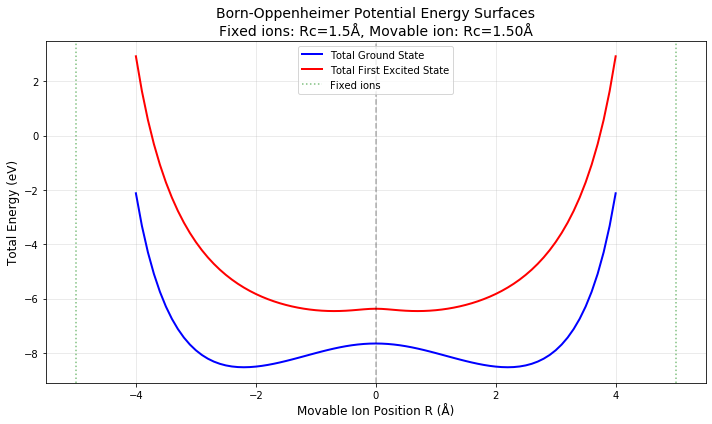


=== Analysis for variable Rc = 1.50 Å ===
Fixed ions at ±5.0 Å with Rc = 1.50 Å
Electronic energy range (ground state): -19.562 to -14.855 eV
Vb (barrier height): 0.875 eV
Band gap at R=0: 1.281 eV
Minimum total energy: -8.530 eV
Equilibrium position: R = 2.200 Å

Calculating Born-Oppenheimer electronic structure:
  Fixed ions at ±5.0 Å with Rc = 1.50 Å
  Movable ion with variable Rc = 1.75 Å
This solves the electronic Hamiltonian for parametric R values using FFT matrix method

Progress:
R = -4.00 Å (1/81)
R = -2.00 Å (21/81)
R = +0.00 Å (41/81)
R = +2.00 Å (61/81)
R = +4.00 Å (81/81)


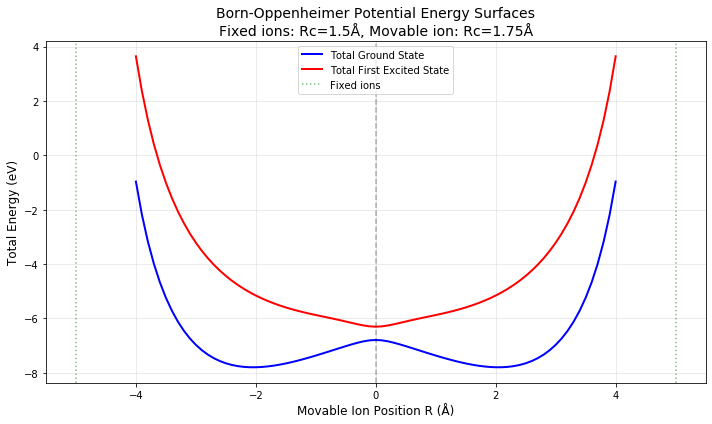


=== Analysis for variable Rc = 1.75 Å ===
Fixed ions at ±5.0 Å with Rc = 1.50 Å
Electronic energy range (ground state): -18.405 to -13.992 eV
Vb (barrier height): 1.004 eV
Band gap at R=0: 0.489 eV
Minimum total energy: -7.796 eV
Equilibrium position: R = -2.000 Å

Calculating Born-Oppenheimer electronic structure:
  Fixed ions at ±5.0 Å with Rc = 1.50 Å
  Movable ion with variable Rc = 2.00 Å
This solves the electronic Hamiltonian for parametric R values using FFT matrix method

Progress:
R = -4.00 Å (1/81)
R = -2.00 Å (21/81)
R = +0.00 Å (41/81)
R = +2.00 Å (61/81)
R = +4.00 Å (81/81)


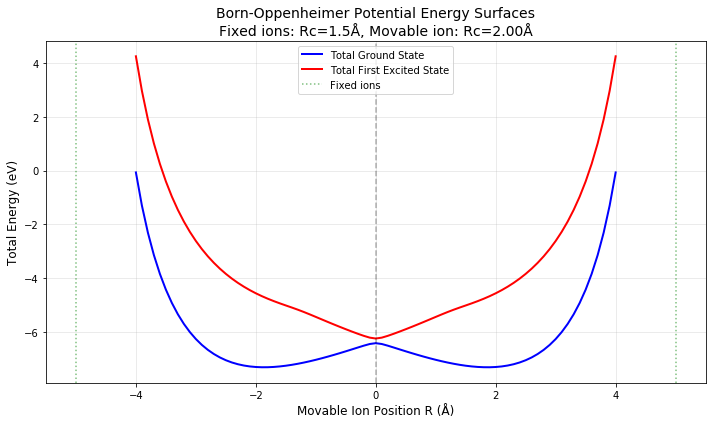


=== Analysis for variable Rc = 2.00 Å ===
Fixed ions at ±5.0 Å with Rc = 1.50 Å
Electronic energy range (ground state): -17.509 to -13.617 eV
Vb (barrier height): 0.895 eV
Band gap at R=0: 0.173 eV
Minimum total energy: -7.312 eV
Equilibrium position: R = 1.900 Å

Calculating Born-Oppenheimer electronic structure:
  Fixed ions at ±5.0 Å with Rc = 1.50 Å
  Movable ion with variable Rc = 2.50 Å
This solves the electronic Hamiltonian for parametric R values using FFT matrix method

Progress:
R = -4.00 Å (1/81)
R = -2.00 Å (21/81)
R = +0.00 Å (41/81)
R = +2.00 Å (61/81)
R = +4.00 Å (81/81)


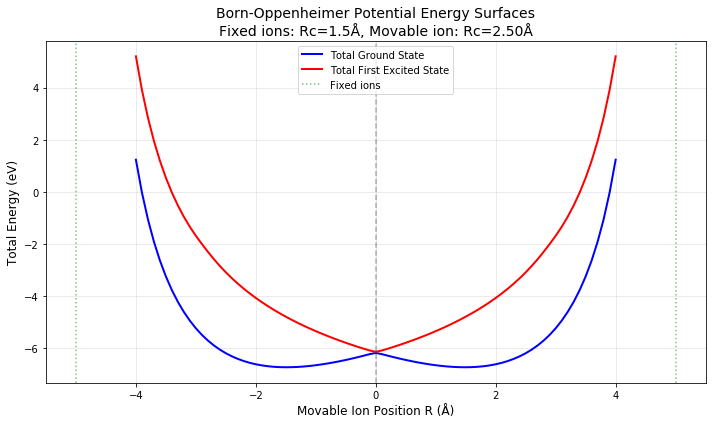


=== Analysis for variable Rc = 2.50 Å ===
Fixed ions at ±5.0 Å with Rc = 1.50 Å
Electronic energy range (ground state): -16.204 to -13.373 eV
Vb (barrier height): 0.549 eV
Band gap at R=0: 0.045 eV
Minimum total energy: -6.723 eV
Equilibrium position: R = 1.500 Å

=== METHOD SUMMARY ===
1. Original method: Imaginary Time Evolution (Split-Step)
2. Second method: Fourier Grid Hamiltonian (FGH)
3. Current method: FFT Matrix Method
All methods solve the same electronic structure problem but use different numerical approaches.

=== SYSTEM SETUP ===
Fixed ions at ±5.0 Å with Rc = 1.50 Å
Movable ion Rc varies: ['1.50', '1.75', '2.00', '2.50'] Å


In [2]:
#FFT method
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.special import erf
import warnings
warnings.filterwarnings('ignore')

# Constants
hbar = 1.054571817e-34      # J·s
m_e = 9.1093837015e-31      # kg
e_charge = 1.602176634e-19  # C
epsilon_0 = 8.8541878128e-12  # F/m
angstrom = 1e-10             # m
eV_to_J = 1.602176634e-19

# Grid setup
N = 1024*2  # Number of grid points
xmax = 10.0 * angstrom
x = np.linspace(-xmax, xmax, N)
dx = x[1] - x[0]

# Momentum grid parameters
dk = 2 * np.pi / (N * dx)  # Momentum spacing

# System parameters
Z = 1.0
Rc_range = [1.5, 1.75, 2.0, 2.5] 
L = 10.0 * angstrom   # Fixed ions at ±L/2 = ±5 Å
Rc_fixed = 1.5 * angstrom  # Fixed Rc for ions at ±L/2

def construct_dft_matrices():
    """
    Construct the DFT and inverse DFT matrices
    W_jk = (1/√N) * w^(jk) where w = e^(2πi/N)
    W_inv_jk = (1/√N) * w^(-jk)
    """
    w = np.exp(2j * np.pi / N)  # Complex exponential
    
    # Forward DFT matrix (1/√N factor included)
    W = np.zeros((N, N), dtype=complex)
    # Inverse DFT matrix (1/√N factor included)  
    W_inv = np.zeros((N, N), dtype=complex)
    
    for j in range(N):
        for k in range(N):
            W[j, k] = (1/np.sqrt(N)) * w**(j * k)
            W_inv[j, k] = (1/np.sqrt(N)) * w**(-j * k)
    
    return W, W_inv

def construct_kinetic_matrix_fft():
    """
    Construct kinetic energy matrix using FFT method:
    T = W_inv * T_diagonal * W
    where T_diagonal contains the kinetic energies T_k = ℏ²k²/(2m)
    """
    # Construct DFT matrices
    W, W_inv = construct_dft_matrices()
    
    # Momentum values (shifted to match FFT indexing)
    # k runs from [0, ..., N/2, -N/2+1, ..., -1] * dk
    k_indices = np.concatenate([np.arange(0, N//2 + 1), np.arange(-N//2 + 1, 0)])
    k_values = k_indices * dk
    
    # Diagonal kinetic energy matrix in momentum space
    T_diagonal = np.diag(hbar**2 * k_values**2 / (2 * m_e))
    
    # Transform back to position space: T = W_inv * T_diagonal * W
    T_matrix = W_inv @ T_diagonal @ W
    
    # Take real part (imaginary part should be negligible due to Hermiticity)
    T_matrix = np.real(T_matrix)
    
    return T_matrix

def electron_ion_potential(r, Rc):
    """
    Electron-ion potential V_eN(r) = -Ze²·erf(r/Rc)/r
    Properly handle the r=0 case with exact limit
    """
    r_abs = np.abs(r)
    
    # For non-zero r, use the regular formula
    mask_nonzero = r_abs > 1e-20
    
    V = np.zeros_like(r)
    
    # Regular case: V = -Ze²·erf(|r|/Rc)/|r|
    prefactor = -Z * e_charge**2 / (4 * np.pi * epsilon_0)
    V[mask_nonzero] = prefactor * erf(r_abs[mask_nonzero]/Rc) / r_abs[mask_nonzero]
    
    # Limit as r→0: V(0) = -Ze²·(2/√π)/Rc
    mask_zero = ~mask_nonzero
    if np.any(mask_zero):
        V[mask_zero] = prefactor * (2.0 / (np.sqrt(np.pi) * Rc))
    
    return V

def ion_ion_coulomb(r):
    """Ion-ion Coulomb repulsion"""
    if np.abs(r) < 1e-20:
        return np.inf
    return e_charge**2 / (4 * np.pi * epsilon_0 * np.abs(r))

def electronic_potential(x, R, Rc_variable):
    """
    Electronic potential V_N(R) + V_e(x,R) for the electronic Hamiltonian
    This is the potential felt by the electron due to the three ions
    Fixed ions at ±L/2 use Rc_fixed = 1.5 Å
    Movable ion at R uses variable Rc_variable
    """
    # Two fixed ions at positions: -L/2, +L/2 with fixed Rc = 1.5 Å
    ion_positions_fixed = [-L/2, L/2]
    
    V_electronic = np.zeros_like(x)
    
    # Sum electron-ion interactions for fixed ions (Rc = 1.5 Å)
    for ion_pos in ion_positions_fixed:
        V_electronic += electron_ion_potential(x - ion_pos, Rc_fixed)
    
    # Add electron-ion interaction for movable ion at R (variable Rc)
    V_electronic += electron_ion_potential(x - R, Rc_variable)   
    
    return V_electronic

def total_energy_at_R(electronic_energy, R):
    """
    Total energy including ion-ion repulsion (for the Born-Oppenheimer surface)
    E_total(R) = E_electronic(R) + V_NN(R)
    """
    # Ion-ion repulsions between three ions
    V_ion_ion = (ion_ion_coulomb(L) +           # between fixed ions at ±L/2
                 ion_ion_coulomb(R + L/2) +     # between movable ion at R and ion at -L/2
                 ion_ion_coulomb(R - L/2))      # between movable ion at R and ion at +L/2
    
    return electronic_energy + V_ion_ion / eV_to_J

def compute_electronic_eigenvalues_fft(V_electronic, T_matrix, n_states=2):
    """
    Compute the first n_states electronic eigenvalues using FFT matrix method
    """
    # Construct potential energy matrix (diagonal)
    V_matrix = np.diag(V_electronic)
    
    # Total Hamiltonian matrix H = T + V
    H_matrix = T_matrix + V_matrix
    
    # Solve eigenvalue problem
    eigenvalues, eigenvectors = eigh(H_matrix)
    
    # Convert to eV and return first n_states
    electronic_energies = eigenvalues[:n_states] / eV_to_J
    
    return electronic_energies

# Construct kinetic energy matrix once using FFT method
print("Constructing kinetic energy matrix using FFT matrix method...")
T_matrix = construct_kinetic_matrix_fft()
print("Kinetic energy matrix constructed.")
print(f"Matrix dimensions: {T_matrix.shape}")
print(f"Matrix is Hermitian: {np.allclose(T_matrix, T_matrix.T)}")

# Parameter sweep for movable ion position - FIXED: Use more points for plotting
R_angstrom = np.linspace(-4.0, 4.0, 81)  # Changed from 1 to 81 points
R_meters = R_angstrom * angstrom

for Rc_val in Rc_range:
    Rc_variable = Rc_val * angstrom  # Variable Rc for movable ion
    
    print(f"\nCalculating Born-Oppenheimer electronic structure:")
    print(f"  Fixed ions at ±{L/(2*angstrom):.1f} Å with Rc = {Rc_fixed/angstrom:.2f} Å")
    print(f"  Movable ion with variable Rc = {Rc_variable/angstrom:.2f} Å")
    print("This solves the electronic Hamiltonian for parametric R values using FFT matrix method")

    electronic_energies = []
    total_energies = []

    print("\nProgress:")
    for i, R in enumerate(R_meters):
        if i % 20 == 0:
            print(f"R = {R_angstrom[i]:+.2f} Å ({i+1}/{len(R_meters)})")
    
        # Electronic potential for this R
        V_electronic = electronic_potential(x, R, Rc_variable)
        
        # Solve electronic Schrödinger equation using FFT matrix method
        E_electronic = compute_electronic_eigenvalues_fft(V_electronic, T_matrix, n_states=2)
    
        # Add ion-ion repulsion to get total Born-Oppenheimer energies
        E_total = [total_energy_at_R(E_elec, R) for E_elec in E_electronic]
        
        electronic_energies.append(E_electronic)
        total_energies.append(E_total)

    electronic_energies = np.array(electronic_energies)
    total_energies = np.array(total_energies)

    # Calculate band gap at R = 0
    R_zero_idx = np.argmin(np.abs(R_angstrom))
    band_gap_at_zero = electronic_energies[R_zero_idx, 1] - electronic_energies[R_zero_idx, 0]

    # Plotting
    fig, ax = plt.subplots(1, figsize=(10, 6))

    # Plot Total Born-Oppenheimer energies (including ion-ion repulsion)
    ax.plot(R_angstrom, total_energies[:, 0], 'b-', lw=2, label='Total Ground State')
    ax.plot(R_angstrom, total_energies[:, 1], 'r-', lw=2, label='Total First Excited State')
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    
    # Mark fixed ion positions
    ax.axvline(x=-L/(2*angstrom), color='g', linestyle=':', alpha=0.5, label='Fixed ions')
    ax.axvline(x=+L/(2*angstrom), color='g', linestyle=':', alpha=0.5)
    
    ax.set_xlabel('Movable Ion Position R (Å)', fontsize=12)
    ax.set_ylabel('Total Energy (eV)', fontsize=12)
    ax.set_title(f'Born-Oppenheimer Potential Energy Surfaces\nFixed ions: Rc={Rc_fixed/angstrom:.1f}Å, Movable ion: Rc={Rc_variable/angstrom:.2f}Å', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()

    # Additional analysis
    print(f"\n=== Analysis for variable Rc = {Rc_variable/angstrom:.2f} Å ===")
    print(f"Fixed ions at ±{L/(2*angstrom):.1f} Å with Rc = {Rc_fixed/angstrom:.2f} Å")
    print(f"Electronic energy range (ground state): {np.min(electronic_energies[:, 0]):.3f} to {np.max(electronic_energies[:, 0]):.3f} eV")
    print(f"Vb (barrier height): {(total_energies[R_zero_idx, 0] - np.min(total_energies[:, 0])):.3f} eV")
    print(f"Band gap at R=0: {band_gap_at_zero:.3f} eV")
    print(f"Minimum total energy: {np.min(total_energies[:, 0]):.3f} eV")
    
    # Find equilibrium positions
    min_idx = np.argmin(total_energies[:, 0])
    print(f"Equilibrium position: R = {R_angstrom[min_idx]:.3f} Å")

# Method comparison summary
print(f"\n=== METHOD SUMMARY ===")
print("1. Original method: Imaginary Time Evolution (Split-Step)")
print("2. Second method: Fourier Grid Hamiltonian (FGH)")
print("3. Current method: FFT Matrix Method")
print("All methods solve the same electronic structure problem but use different numerical approaches.")
print(f"\n=== SYSTEM SETUP ===")
print(f"Fixed ions at ±{L/(2*angstrom):.1f} Å with Rc = {Rc_fixed/angstrom:.2f} Å")
print(f"Movable ion Rc varies: {[f'{rc:.2f}' for rc in Rc_range]} Å")

Calculating Born-Oppenheimer electronic structure with Rc = 1.50 Å
This solves the electronic Hamiltonian for parametric R values

Progress:
R = -4.00 Å (1/201)
R = -3.60 Å (11/201)
R = -3.20 Å (21/201)
R = -2.80 Å (31/201)
R = -2.40 Å (41/201)
R = -2.00 Å (51/201)
R = -1.60 Å (61/201)
R = -1.20 Å (71/201)
R = -0.80 Å (81/201)
R = -0.40 Å (91/201)
R = +0.00 Å (101/201)
R = +0.40 Å (111/201)
R = +0.80 Å (121/201)
R = +1.20 Å (131/201)
R = +1.60 Å (141/201)
R = +2.00 Å (151/201)
R = +2.40 Å (161/201)
R = +2.80 Å (171/201)
R = +3.20 Å (181/201)
R = +3.60 Å (191/201)
R = +4.00 Å (201/201)


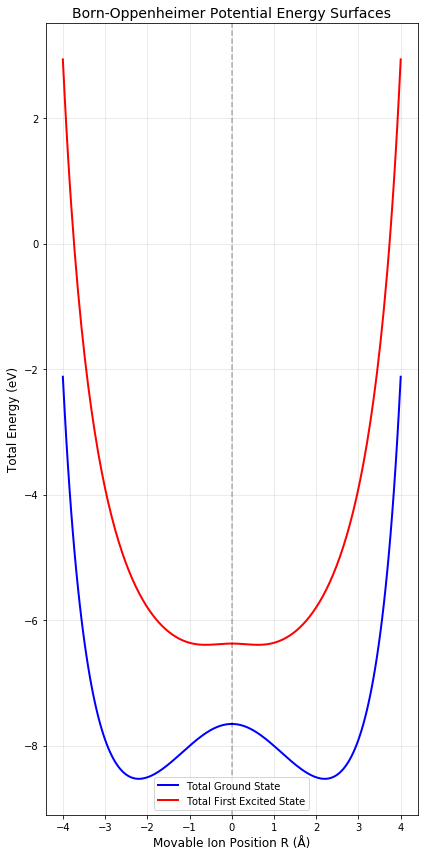


=== Additional Analysis ===
Electronic energy range (ground state): -19.562 to -14.855 eV
Vb: 0.874 eV
Band gap range: 1.281 eV
Calculating Born-Oppenheimer electronic structure with Rc = 1.75 Å
This solves the electronic Hamiltonian for parametric R values

Progress:
R = -4.00 Å (1/201)
R = -3.60 Å (11/201)
R = -3.20 Å (21/201)
R = -2.80 Å (31/201)
R = -2.40 Å (41/201)
R = -2.00 Å (51/201)
R = -1.60 Å (61/201)
R = -1.20 Å (71/201)
R = -0.80 Å (81/201)
R = -0.40 Å (91/201)
R = +0.00 Å (101/201)
R = +0.40 Å (111/201)
R = +0.80 Å (121/201)
R = +1.20 Å (131/201)
R = +1.60 Å (141/201)
R = +2.00 Å (151/201)
R = +2.40 Å (161/201)
R = +2.80 Å (171/201)
R = +3.20 Å (181/201)
R = +3.60 Å (191/201)
R = +4.00 Å (201/201)


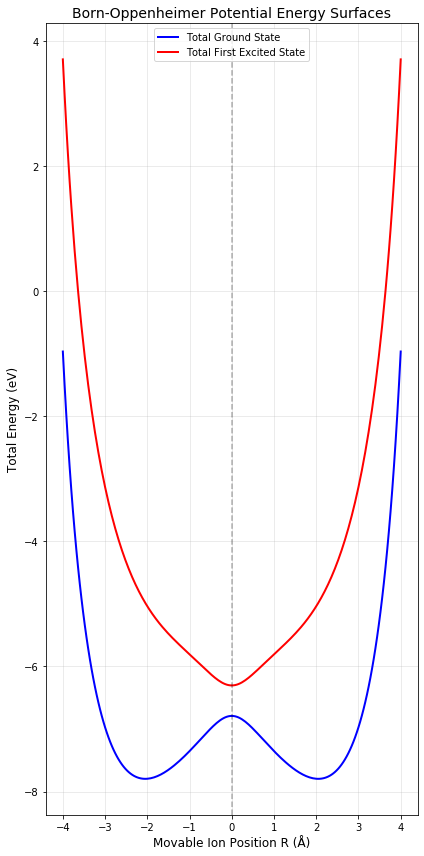


=== Additional Analysis ===
Electronic energy range (ground state): -18.405 to -13.990 eV
Vb: 1.004 eV
Band gap range: 0.490 eV
Calculating Born-Oppenheimer electronic structure with Rc = 2.00 Å
This solves the electronic Hamiltonian for parametric R values

Progress:
R = -4.00 Å (1/201)
R = -3.60 Å (11/201)
R = -3.20 Å (21/201)
R = -2.80 Å (31/201)
R = -2.40 Å (41/201)
R = -2.00 Å (51/201)
R = -1.60 Å (61/201)
R = -1.20 Å (71/201)
R = -0.80 Å (81/201)
R = -0.40 Å (91/201)
R = +0.00 Å (101/201)
R = +0.40 Å (111/201)
R = +0.80 Å (121/201)
R = +1.20 Å (131/201)
R = +1.60 Å (141/201)
R = +2.00 Å (151/201)
R = +2.40 Å (161/201)
R = +2.80 Å (171/201)
R = +3.20 Å (181/201)
R = +3.60 Å (191/201)
R = +4.00 Å (201/201)


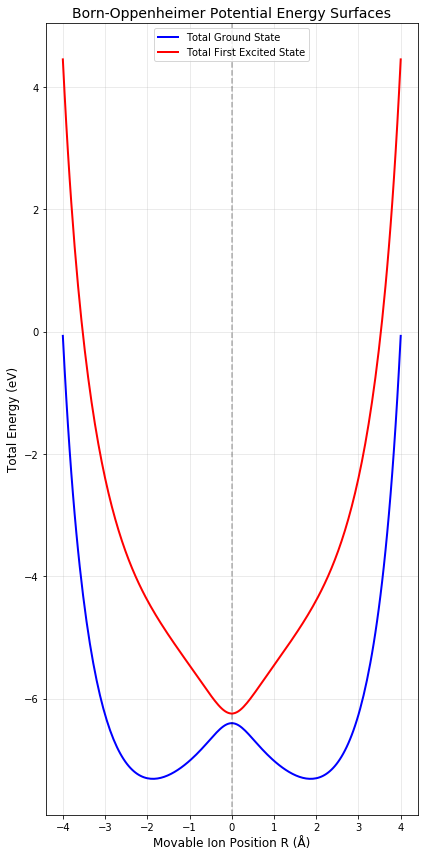


=== Additional Analysis ===
Electronic energy range (ground state): -17.509 to -13.601 eV
Vb: 0.908 eV
Band gap range: 0.162 eV
Calculating Born-Oppenheimer electronic structure with Rc = 2.50 Å
This solves the electronic Hamiltonian for parametric R values

Progress:
R = -4.00 Å (1/201)
R = -3.60 Å (11/201)
R = -3.20 Å (21/201)
R = -2.80 Å (31/201)
R = -2.40 Å (41/201)
R = -2.00 Å (51/201)
R = -1.60 Å (61/201)
R = -1.20 Å (71/201)
R = -0.80 Å (81/201)
R = -0.40 Å (91/201)
R = +0.00 Å (101/201)
R = +0.40 Å (111/201)
R = +0.80 Å (121/201)
R = +1.20 Å (131/201)
R = +1.60 Å (141/201)
R = +2.00 Å (151/201)
R = +2.40 Å (161/201)
R = +2.80 Å (171/201)
R = +3.20 Å (181/201)
R = +3.60 Å (191/201)
R = +4.00 Å (201/201)


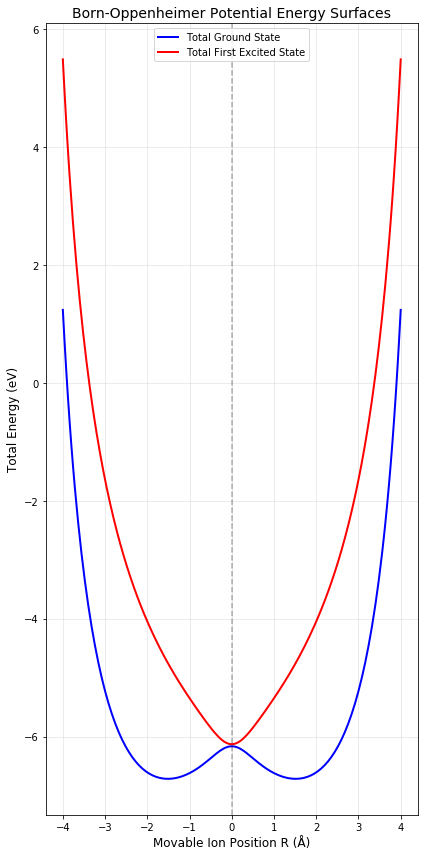


=== Additional Analysis ===
Electronic energy range (ground state): -16.204 to -13.364 eV
Vb: 0.550 eV
Band gap range: 0.039 eV


In [3]:
#method 2 Fourier transform method- Imaginary time evolution and split-step method 
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from scipy.special import erf
import warnings
warnings.filterwarnings('ignore')

# Constants
hbar = 1.054571817e-34      # J·s
m_e = 9.1093837015e-31      # kg
e_charge = 1.602176634e-19  # C
epsilon_0 = 8.8541878128e-12  # F/m
angstrom = 1e-10             # m
eV_to_J = 1.602176634e-19

# Grid setup
N = 1024  # Increased for better resolution
xmax = 10.0 * angstrom  # Increased range
x = np.linspace(-xmax, xmax, N)
dx = x[1] - x[0]

# Momentum grid for FFT
k = 2 * np.pi * fftfreq(N, d=dx)
T_k = (hbar**2 * k**2) / (2 * m_e)  # Kinetic energy operator in k-space

# System parameters
Z = 1.0
Rc_array = [1.5, 1.75, 2.0, 2.5] 
L = 10.0 * angstrom   # Fixed ions at ±L/2 = ±5 Å

from IPython.core.display import display, HTML

display(HTML('''
<style>
.output_scroll {
    overflow-y: visible !important;
    max-height: none !important;
}
</style>
'''))

def electron_ion_potential(r, Rc):
    """
    Electron-ion potential V_eN(r) = -Ze²·erf(r/Rc)/r
    Properly handle the r=0 case with exact limit
    """
    r_abs = np.abs(r)
    
    # For non-zero r, use the regular formula
    mask_nonzero = r_abs > 1e-20  # Much smaller threshold
    
    V = np.zeros_like(r)
    
    # Regular case: V = -Ze²·erf(|r|/Rc)/|r|
    prefactor = -Z * e_charge**2 / (4 * np.pi * epsilon_0)
    V[mask_nonzero] = prefactor * erf(r_abs[mask_nonzero]/Rc) / r_abs[mask_nonzero]
    
    # Limit as r→0: V(0) = -Ze²·(2/√π)/Rc
    mask_zero = ~mask_nonzero
    if np.any(mask_zero):
        V[mask_zero] = prefactor * (2.0 / (np.sqrt(np.pi) * Rc))
    
    return V

def ion_ion_coulomb(r):
    """Ion-ion Coulomb repulsion"""
    if np.abs(r) < 1e-20:
        return np.inf  # This should never happen in practice
    return e_charge**2 / (4 * np.pi * epsilon_0 * np.abs(r))

def electronic_potential(x, R):
    """
    Electronic potential V_N(R) + V_e(x,R) for the electronic Hamiltonian
    This is the potential felt by the electron due to the three ions
    """
    # Three ions at positions: -L/2, +L/2, and R
    ion_positions = [-L/2, L/2]
    
    V_electronic = np.zeros_like(x)
    
    # Sum electron-ion interactions
    for ion_pos in ion_positions:
        V_electronic += electron_ion_potential(x - ion_pos, 1.5 * angstrom)
    V_electronic += electron_ion_potential(x - R, Rc)
    return V_electronic

def total_energy_at_R(electronic_energy, R):
    """
    Total energy including ion-ion repulsion (for the Born-Oppenheimer surface)
    E_total(R) = E_electronic(R) + V_NN(R)
    """
    # Ion-ion repulsions between three ions
    V_ion_ion = (ion_ion_coulomb(L) +           # between fixed ions at ±L/2
                 ion_ion_coulomb(R + L/2) +     # between movable ion at R and ion at -L/2
                 ion_ion_coulomb(R - L/2))      # between movable ion at R and ion at +L/2
    
    return electronic_energy + V_ion_ion / eV_to_J

def apply_hamiltonian_FFT(psi, V_electronic):
    """Apply electronic Hamiltonian using FFT for kinetic energy"""
    # Kinetic energy in k-space
    psi_k = fft(psi)
    T_psi = ifft(T_k * psi_k).real  # Take real part to avoid numerical issues
    
    # Potential energy in x-space
    V_psi = V_electronic * psi
    
    return T_psi + V_psi

def gram_schmidt(vectors):
    """Gram-Schmidt orthogonalization"""
    orthogonal = []
    for v in vectors:
        v = v.astype(complex)  # Ensure complex arithmetic
        # Subtract projections onto previous vectors
        for u in orthogonal:
            projection = np.trapz(np.conj(u) * v, dx=dx)
            v = v - projection * u
        # Normalize
        norm = np.sqrt(np.trapz(np.abs(v)**2, dx=dx))
        if norm > 1e-12:
            orthogonal.append(v / norm)
    return orthogonal

def compute_electronic_eigenvalues(V_electronic, n_states=2):
    """
    Compute the first n_states electronic eigenvalues using imaginary time evolution
    """
    # Initialize different starting wavefunctions
    sigma = 3.0 * angstrom  # Narrower initial guess
    
    psi_list = []
    psi_list.append(np.exp(-(x)**2 / (2 * sigma**2)))  # Symmetric Gaussian
    psi_list.append(x * np.exp(-(x)**2 / (2 * sigma**2)))  # Antisymmetric
    
    if n_states > 2:
        psi_list.append((x**2 - sigma**2) * np.exp(-(x)**2 / (2 * sigma**2)))  # Higher order
    
    # Take only the number of states we need
    psi_list = psi_list[:n_states]
    
    # Convert to complex and normalize
    for i in range(len(psi_list)):
        psi_list[i] = psi_list[i].astype(complex)
        norm = np.sqrt(np.trapz(np.abs(psi_list[i])**2, dx=dx))
        psi_list[i] /= norm
    
    # Imaginary time evolution parameters
    dt = 5e-19  # Smaller time step for stability
    n_steps = 2000
    
    for step in range(n_steps):
        # Apply split-step evolution: exp(-V*dt/2) * exp(-T*dt) * exp(-V*dt/2)
        for i in range(len(psi_list)):
            # First potential step
            psi_list[i] *= np.exp(-V_electronic * dt / (2 * hbar))
            
            # Kinetic step in k-space
            psi_k = fft(psi_list[i])
            psi_k *= np.exp(-T_k * dt / hbar)
            psi_list[i] = ifft(psi_k)
            
            # Second potential step
            psi_list[i] *= np.exp(-V_electronic * dt / (2 * hbar))
        
        # Orthogonalize every 20 steps to prevent convergence to same state
        if step % 20 == 0 and step > 0:
            psi_list = gram_schmidt(psi_list)
    
    # Final orthogonalization
    psi_list = gram_schmidt(psi_list)
    
    # Compute electronic energies
    electronic_energies = []
    for psi in psi_list:
        H_psi = apply_hamiltonian_FFT(psi, V_electronic)
        E_electronic = np.trapz(np.conj(psi) * H_psi, dx=dx).real
        electronic_energies.append(E_electronic / eV_to_J)  # Convert to eV
    
    # Sort energies to ensure ground state is first
    electronic_energies.sort()
    
    return electronic_energies[:n_states]

# Parameter sweep for movable ion position
R_angstrom = np.linspace(-4.0, 4.0, 201)
R_meters = R_angstrom * angstrom

for Rc_val in Rc_array:
    Rc = Rc_val * angstrom
    
    print(f"Calculating Born-Oppenheimer electronic structure with Rc = {Rc/angstrom:.2f} Å")
    print("This solves the electronic Hamiltonian for parametric R values")


    electronic_energies = []
    total_energies = []

    print("\nProgress:")
    for i, R in enumerate(R_meters):
        if i % 10 == 0:
            print(f"R = {R_angstrom[i]:+.2f} Å ({i+1}/{len(R_meters)})")
    
        # Electronic potential for this R
        V_electronic = electronic_potential(x, R)
        
        # Solve electronic Schrödinger equation
        E_electronic = compute_electronic_eigenvalues(V_electronic, n_states=2)
    
        # Add ion-ion repulsion to get total Born-Oppenheimer energies
        E_total = [total_energy_at_R(E_elec, R) for E_elec in E_electronic]
        
        electronic_energies.append(E_electronic)
        total_energies.append(E_total)

    electronic_energies = np.array(electronic_energies)
    total_energies = np.array(total_energies)

    # Calculate band gap at R = 0
    R_zero_idx = np.argmin(np.abs(R_angstrom))
    band_gap_at_zero = electronic_energies[R_zero_idx, 1] - electronic_energies[R_zero_idx, 0]

    
    # Plotting
    fig, (ax2) = plt.subplots(1, figsize=(6, 12))



    # Plot 2: Total Born-Oppenheimer energies (including ion-ion repulsion)
    ax2.plot(R_angstrom, total_energies[:, 0], 'b-', lw=2, label='Total Ground State')
    ax2.plot(R_angstrom, total_energies[:, 1], 'r-', lw=2, label='Total First Excited State')
    ax2.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    ax2.set_xlabel('Movable Ion Position R (Å)', fontsize=12)
    ax2.set_ylabel('Total Energy (eV)', fontsize=12)
    ax2.set_title('Born-Oppenheimer Potential Energy Surfaces', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Additional analysis
    print(f"\n=== Additional Analysis ===")
    print(f"Electronic energy range (ground state): {np.min(electronic_energies[:, 0]):.3f} to {np.max(electronic_energies[:, 0]):.3f} eV")
    print(f"Vb: {(total_energies[101, 0] - np.min(total_energies[:, 0])):.3f} eV")
    print(f"Band gap range: {(total_energies[101, 1] - total_energies[101, 0]):.3f} eV")
    


Calculating for Rc = 1.50 Å
Computing eigenvalues...
Progress: 0/100
Progress: 20/100
Progress: 40/100
Progress: 60/100
Progress: 80/100


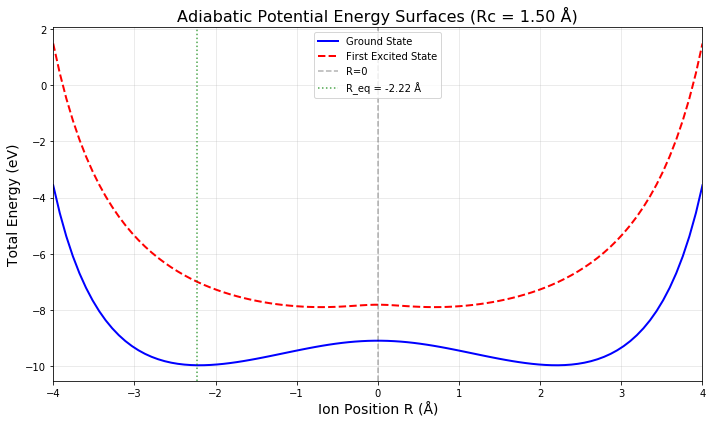


=== Analysis for Rc = 1.50 Å ===
Delta (band gap at R=0): 1.2806 eV
Vb (barrier height): 0.8736 eV
Minimum energy: -9.9696 eV
Energy at R=0: -9.0961 eV
Equilibrium position R_eq: -2.222 Å
Energy range (ground state): -9.9696 to -3.5627 eV

Calculating for Rc = 1.75 Å
Computing eigenvalues...
Progress: 0/100
Progress: 20/100
Progress: 40/100
Progress: 60/100
Progress: 80/100


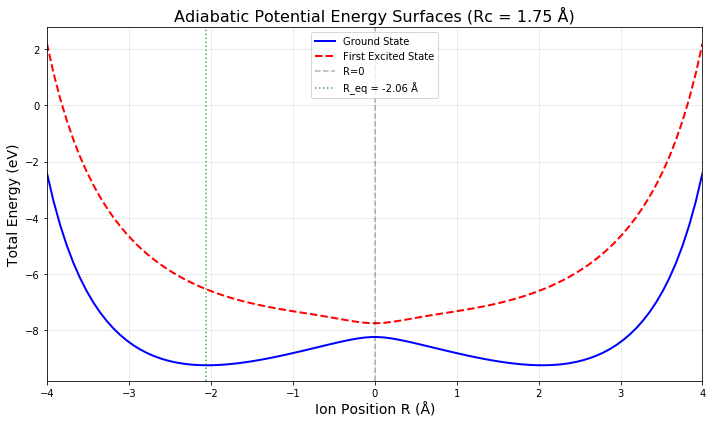


=== Analysis for Rc = 1.75 Å ===
Delta (band gap at R=0): 0.4925 eV
Vb (barrier height): 1.0029 eV
Minimum energy: -9.2371 eV
Energy at R=0: -8.2343 eV
Equilibrium position R_eq: -2.061 Å
Energy range (ground state): -9.2371 to -2.4057 eV

Calculating for Rc = 2.00 Å
Computing eigenvalues...
Progress: 0/100
Progress: 20/100
Progress: 40/100
Progress: 60/100
Progress: 80/100


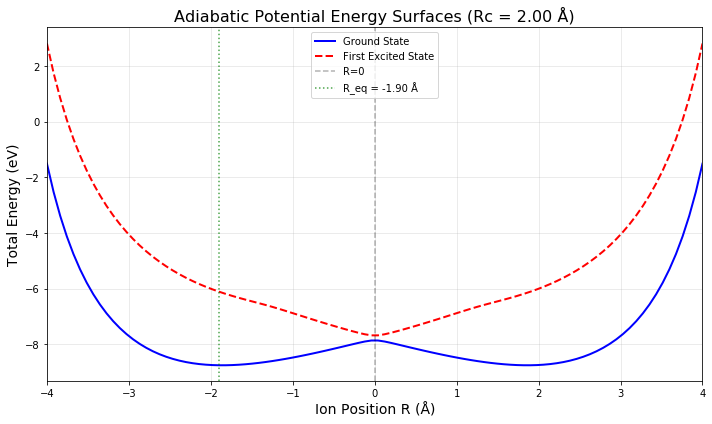


=== Analysis for Rc = 2.00 Å ===
Delta (band gap at R=0): 0.1847 eV
Vb (barrier height): 0.8894 eV
Minimum energy: -8.7523 eV
Energy at R=0: -7.8629 eV
Equilibrium position R_eq: -1.899 Å
Energy range (ground state): -8.7523 to -1.5099 eV

Calculating for Rc = 2.50 Å
Computing eigenvalues...
Progress: 0/100
Progress: 20/100
Progress: 40/100
Progress: 60/100
Progress: 80/100


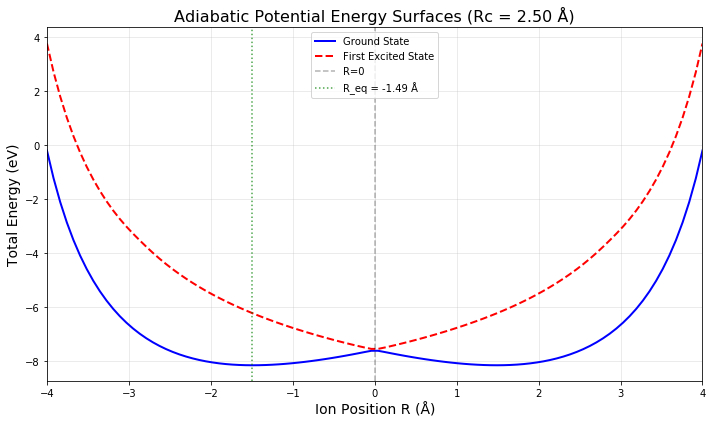


=== Analysis for Rc = 2.50 Å ===
Delta (band gap at R=0): 0.0695 eV
Vb (barrier height): 0.5370 eV
Minimum energy: -8.1629 eV
Energy at R=0: -7.6259 eV
Equilibrium position R_eq: -1.495 Å
Energy range (ground state): -8.1629 to -0.2046 eV


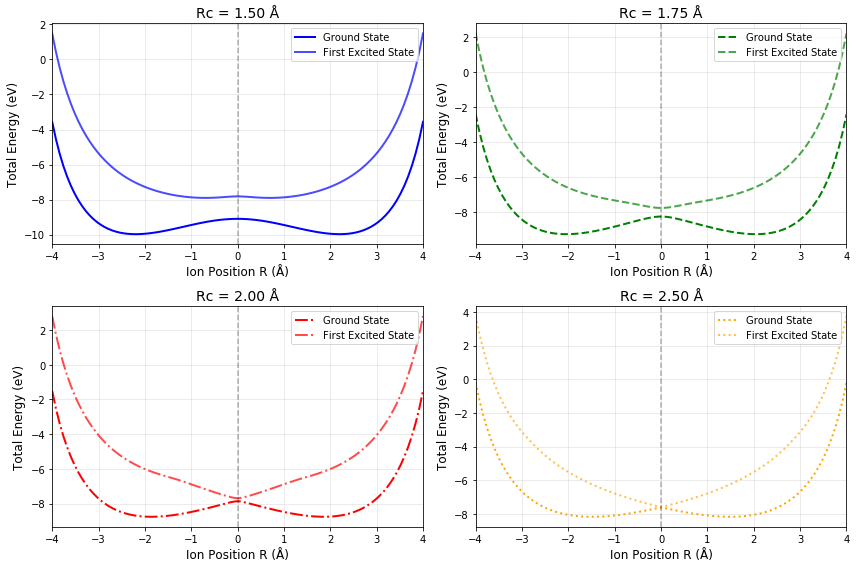


                            SUMMARY TABLE                             
Rc (Å)     Delta (eV)   Vb (eV)      R_eq (Å)     E_min (eV)  
----------------------------------------------------------------------
1.50       1.2806       0.8736       -2.222       -9.9696     
1.75       0.4925       1.0029       -2.061       -9.2371     
2.00       0.1847       0.8894       -1.899       -8.7523     
2.50       0.0695       0.5370       -1.495       -8.1629     

Definitions:
- Delta: Band gap at R=0 (E1(R=0) - E0(R=0))
- Vb: Barrier height (E0(R=0) - min(E0(R)))
- R_eq: Equilibrium position (R where E0 is minimum)
- E_min: Minimum ground state energy


In [4]:
#finite difference
import numpy as np
from scipy.linalg import eigh
from scipy.special import erf
import matplotlib.pyplot as plt

# Fundamental constants in SI units
hbar = 1.054571817e-34      # J·s
m_e = 9.1093837015e-31      # kg
e_charge = 1.602176634e-19  # C
epsilon_0 = 8.8541878128e-12  # F/m
angstrom = 1e-10             # 1 Å = 1e-10 m
eV_to_J = 1.602176634e-19    # Conversion factor

# System parameters
Z = 1.0
Rc_range = [1.5, 1.75, 2.0, 2.5]  # Multiple cutoff radii in Angstrom
L = 10.0 * angstrom         # Distance between fixed ions
xmax = 40.0 * angstrom      # Spatial grid size
R_fix = 1.5 * angstrom
# Spatial grid setup
N = 1000
x = np.linspace(-xmax, xmax, N)
dx = x[1] - x[0]

def regularized_potential(r, Rc):
    """Electron-ion potential with regularization"""
    if abs(r) < 1e-18:  # Avoid division by zero
        return -Z * (e_charge**2 / (4*np.pi*epsilon_0)) * 2/(np.sqrt(np.pi)*Rc)
    return -Z * (e_charge**2 / (4*np.pi*epsilon_0)) * erf(abs(r)/Rc)/abs(r)

def coulombic_potential(r):
    """Ion-ion Coulomb potential"""
    r_abs = np.abs(r)
    if r_abs < 1e-18:
        return 0.0  # Avoid self-interaction
    return (e_charge**2 / (4*np.pi*epsilon_0)) / r_abs

def total_potential(x, R, Rc):
    """Total potential including all interactions"""
    return (regularized_potential(x + L/2,R_fix ) + 
            regularized_potential(x - L/2, R_fix) + 
            regularized_potential(x - R, Rc) +
            coulombic_potential(L/2 + R) +   # Ion-ion repulsion 1
            coulombic_potential(L/2 - R))    # Ion-ion repulsion 2

def build_hamiltonian(R, Rc):
    """Construct full Hamiltonian matrix"""
    # Kinetic energy matrix (finite difference)
    main_diag = -2 * np.ones(N)/dx**2
    off_diag = np.ones(N-1)/dx**2
    D2 = np.diag(main_diag) + np.diag(off_diag, 1) + np.diag(off_diag, -1)
    T = -(hbar**2/(2*m_e)) * D2
    
    # Potential energy matrix (includes all terms)
    V = np.diag([total_potential(xi, R, Rc) for xi in x])
    
    return T + V

# Parameter sweep configuration
R_angstrom = np.linspace(-4.0, 4.0, 100)
R_meters = R_angstrom * angstrom

# Store results for all Rc values
all_results = {}

for Rc_val in Rc_range:
    Rc = Rc_val * angstrom
    print(f"\nCalculating for Rc = {Rc_val:.2f} Å")
    
    energy_levels = []
    print("Computing eigenvalues...")
    
    for i, R in enumerate(R_meters):
        if i % 20 == 0:
            print(f"Progress: {i}/{len(R_meters)}")
        
        H = build_hamiltonian(R, Rc)
        eigenvalues = eigh(H, eigvals_only=True, eigvals=(0, 1))
        energy_levels.append(eigenvalues / eV_to_J)  # Convert J → eV
    
    energy_levels = np.array(energy_levels)
    all_results[Rc_val] = energy_levels
    
    # Find R=0 index for analysis
    R_zero_idx = np.argmin(np.abs(R_angstrom))
    
    # Calculate delta (band gap at R=0)
    delta = energy_levels[R_zero_idx, 1] - energy_levels[R_zero_idx, 0]
    
    # Calculate Vb (barrier height)
    # Vb is the difference between energy at R=0 and minimum energy
    E_at_zero = energy_levels[R_zero_idx, 0]
    E_min = np.min(energy_levels[:, 0])
    Vb = E_at_zero - E_min
    
    # Find equilibrium position (minimum energy position)
    min_idx = np.argmin(energy_levels[:, 0])
    R_eq = R_angstrom[min_idx]
    
    # Plotting results for this Rc
    plt.figure(figsize=(10, 6))
    plt.plot(R_angstrom, energy_levels[:, 0], 'b-', lw=2, label='Ground State')
    plt.plot(R_angstrom, energy_levels[:, 1], 'r--', lw=2, label='First Excited State')
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3, label='R=0')
    plt.axvline(x=R_eq, color='g', linestyle=':', alpha=0.7, label=f'R_eq = {R_eq:.2f} Å')
    plt.xlabel('Ion Position R (Å)', fontsize=14)
    plt.ylabel('Total Energy (eV)', fontsize=14)
    plt.title(f'Adiabatic Potential Energy Surfaces (Rc = {Rc_val:.2f} Å)', fontsize=16)
    plt.xlim(-4, 4)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print analysis results
    print(f"\n=== Analysis for Rc = {Rc_val:.2f} Å ===")
    print(f"Delta (band gap at R=0): {delta:.4f} eV")
    print(f"Vb (barrier height): {Vb:.4f} eV")
    print(f"Minimum energy: {E_min:.4f} eV")
    print(f"Energy at R=0: {E_at_zero:.4f} eV")
    print(f"Equilibrium position R_eq: {R_eq:.3f} Å")
    print(f"Energy range (ground state): {np.min(energy_levels[:, 0]):.4f} to {np.max(energy_levels[:, 0]):.4f} eV")

# Summary comparison plot
plt.figure(figsize=(12, 8))

colors = ['blue', 'green', 'red', 'orange']
linestyles = ['-', '--', '-.', ':']

for i, Rc_val in enumerate(Rc_range):
    energy_levels = all_results[Rc_val]
    plt.subplot(2, 2, i+1)
    plt.plot(R_angstrom, energy_levels[:, 0], color=colors[i], 
             linestyle=linestyles[i], lw=2, label='Ground State')
    plt.plot(R_angstrom, energy_levels[:, 1], color=colors[i], 
             linestyle=linestyles[i], lw=2, alpha=0.7, label='First Excited State')
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    plt.xlabel('Ion Position R (Å)', fontsize=12)
    plt.ylabel('Total Energy (eV)', fontsize=12)
    plt.title(f'Rc = {Rc_val:.2f} Å', fontsize=14)
    plt.xlim(-4, 4)
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print(f"\n{'='*70}")
print(f"{'SUMMARY TABLE':^70}")
print(f"{'='*70}")
print(f"{'Rc (Å)':<10} {'Delta (eV)':<12} {'Vb (eV)':<12} {'R_eq (Å)':<12} {'E_min (eV)':<12}")
print(f"{'-'*70}")

for Rc_val in Rc_range:
    energy_levels = all_results[Rc_val]
    R_zero_idx = np.argmin(np.abs(R_angstrom))
    
    delta = energy_levels[R_zero_idx, 1] - energy_levels[R_zero_idx, 0]
    E_at_zero = energy_levels[R_zero_idx, 0]
    E_min = np.min(energy_levels[:, 0])
    Vb = E_at_zero - E_min
    min_idx = np.argmin(energy_levels[:, 0])
    R_eq = R_angstrom[min_idx]
    
    print(f"{Rc_val:<10.2f} {delta:<12.4f} {Vb:<12.4f} {R_eq:<12.3f} {E_min:<12.4f}")

print(f"{'='*70}")
print("\nDefinitions:")
print("- Delta: Band gap at R=0 (E1(R=0) - E0(R=0))")
print("- Vb: Barrier height (E0(R=0) - min(E0(R)))")
print("- R_eq: Equilibrium position (R where E0 is minimum)")
print("- E_min: Minimum ground state energy")